# Check GPU

In [2]:
!nvidia-smi

Fri Oct 21 14:18:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from imutils import paths

# Load dataset

In [ ]:
CATEGORIES = ['heart', 'oblong', 'oval', 'round', 'square']
epochs=50
batch_size = 32
IMG_SIZE = 224

In [ ]:
trainDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/data/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

testDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/data/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

# Load pretrained model

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
pretrainedModel = VGG16(input_shape=IMG_SHAPE,
              include_top=False,
              weights='imagenet')
pretrainedModel.trainable = False
pretrainedModel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Build model

In [ ]:
fullModel = keras.Sequential([
    layers.InputLayer(input_shape=IMG_SHAPE),

    layers.Rescaling(1./255),

    pretrainedModel,
    
    layers.Flatten(),
    layers.Dense(5)
])

In [ ]:
fullModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 5)                 125445    
                                                                 
Total params: 14,840,133
Trainable params: 125,445
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
fullModel.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
checkpointPath = "/content/drive/MyDrive/CS331/FromRaw/VGG16/checkpoint/model-{epoch:02d}-{val_accuracy:.2f}.h5"

In [ ]:
modelEarlyStopping = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=5,
    verbose=1,
    monitor='val_loss',
    restore_best_weights=False,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose = 1,
    mode='max'
)


# Train model

In [ ]:
with tf.device('/gpu:0'):
    history = fullModel.fit(
            trainDS,
            validation_data=testDS,
            epochs=epochs,
            callbacks = [modelEarlyStopping, modelCheckpoint]
    )

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.5116 - accuracy: 0.4097
Epoch 1: val_accuracy improved from -inf to 0.44144, saving model to /content/drive/MyDrive/CS331/FromRaw/VGG16/checkpoint/model-01-0.44.h5
125/125 [==============================] - 713s 5s/step - loss: 1.5116 - accuracy: 0.4097 - val_loss: 1.4486 - val_accuracy: 0.4414
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.8696 - accuracy: 0.6743
Epoch 2: val_accuracy improved from 0.44144 to 0.51451, saving model to /content/drive/MyDrive/CS331/FromRaw/VGG16/checkpoint/model-02-0.51.h5
125/125 [==============================] - 34s 263ms/step - loss: 0.8696 - accuracy: 0.6743 - val_loss: 1.3277 - val_accuracy: 0.5145
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.8054
Epoch 3: val_accuracy improved from 0.51451 to 0.51752, saving model to /content/drive/MyDrive/CS331/FromRaw/VGG16/checkpoint/model-03-0.52.h5
125/125 [===========

# Plot loss and accuracy

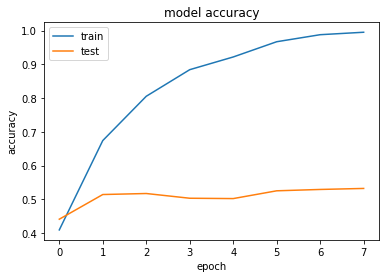

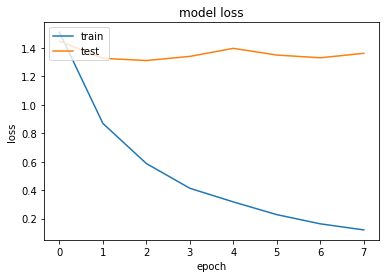

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing model

In [4]:
def loadData(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    for imagePath in tqdm(imagePaths):
        label = imagePath.split(os.path.sep)[-2]
        # Read image
        image = cv2.imread(imagePath)

        # Resize
        imageResize = cv2.resize(image, (224,224))


        data.append(imageResize)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    return data, labels

In [5]:
xTest, yTest = loadData(('/content/drive/MyDrive/CS331/data/test'))

100%|██████████| 1000/1000 [10:57<00:00,  1.52it/s]


In [ ]:
newModel = keras.models.load_model('/content/drive/MyDrive/CS331/FromRaw/VGG16/checkpoint/model-08-0.53.h5')

In [ ]:
zScores = newModel.predict(xTest)
yPred = np.argmax(zScores, axis=1)
corrects = (yTest == yPred).sum()
print(f'Model predict {corrects}/{len(yTest)} corrects')

32/32 [==============================] - 5s 144ms/step
Model predict 485/1000 corrects


## Confusion matrix

Text(103.5, 0.5, 'Truth')

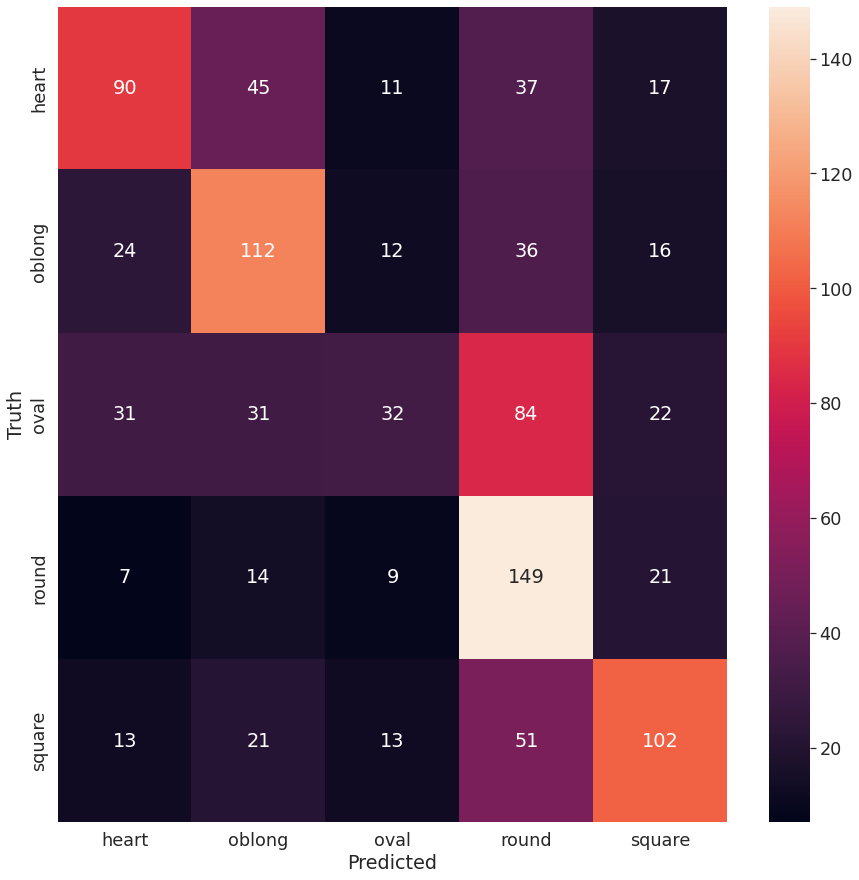

In [ ]:
cm = tf.math.confusion_matrix(labels=yTest, predictions=yPred)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Classification report

In [ ]:
print(classification_report(yTest, yPred,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.55      0.45      0.49       200
      oblong       0.50      0.56      0.53       200
        oval       0.42      0.16      0.23       200
       round       0.42      0.74      0.54       200
      square       0.57      0.51      0.54       200

    accuracy                           0.48      1000
   macro avg       0.49      0.48      0.47      1000
weighted avg       0.49      0.48      0.47      1000

